# Interactions between ProTα and Histone H1.0

In [1]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

## Data preparation

### Templates

In [7]:
# Defining UniProt IDs / Trivial IDs
entries = {
    'H1-0': 'P07305',
    'ProTa': 'P06454',
}
templates = pd.DataFrame({'uniprot_id': entries.values(),
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None},
                          index=entries.keys())

In [8]:
# Collecting metadata
for id, row in templates.iterrows():
    name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    templates.loc[id] = {
        'uniprot_id': row.uniprot_id,
        'name': name,
        'description': desc,
        'species': spec,
        'sequence': seq}

In [9]:
# Viewing final templates
templates

,uniprot_id,name,description,species,sequence
H1-0,P07305,H10_HUMAN,Histone H1.0,Homo sapiens (Human),MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...
ProTa,P06454,PTMA_HUMAN,Prothymosin alpha,Homo sapiens (Human),MSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNAENEENGE...


In [10]:
# Saving metadata
metadata = {'templates': templates.to_dict(orient='index')}
with open('prota_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Data

In [9]:
# Getting template metadata
with open('prota_h1-0.json', 'r') as file:
    metadata = json.load(file)

In [12]:
# Getting IDR of H1.0 (C-terminal IDR)
seq, loc, reg = data_utils.get_protein_idr(uniprot_id=metadata['templates']['H1-0']['uniprot_id'], i_idr=-1, length_order=False)
H10 = {'template': 'H1-0', 'sequence': seq, 'location': loc, 'region': 'CTD', 'variant': 'Wild type'}

# Getting IDR of ProTa (Full-length IDP)
seq, loc, reg = data_utils.get_protein_idr(uniprot_id=metadata['templates']['ProTa']['uniprot_id'], i_idr=-1, length_order=True)
ProTa = {'template': 'ProTa', 'sequence': seq, 'location': loc, 'region': 'FL', 'variant': 'Wild type'}

In [13]:
# Assembling all data entries for simulation
data = pd.DataFrame([H10, ProTa], index = ['H1-0_WT', 'ProTa_WT'])
data

,template,sequence,location,region,variant
H1-0_WT,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type
ProTa_WT,ProTa,MSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNAENEENGE...,0:111,FL,Wild type


In [14]:
# Saving sequences
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Iterating over rows
for index, cols in data.iterrows():
    id = index.upper()
    desc = cols['variant']
    seq = cols['sequence']

    # Saving as FASTA format (Though one-line sequence)
    filepath = 'data/' + id + '.fasta'
    with open(filepath, 'w') as file:
        file.write('>' + id + ' ' + desc + '\n')
        file.write(seq + '\n')

In [16]:
# Saving metadata
metadata['data'] = data.to_dict(orient='index')
with open('prota_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Topologies

#### Compact frames

In [ ]:
# Getting compact frame topologies
cond = 'default'
trajs = {}

# Looping over proteins
for prot in ['PROTA_WT', 'H1-0_WT']:

    # Loading trajectory
    traj_path = f'results/single_chain/{cond}/{prot}/traj.dcd'
    top_path  = f'results/single_chain/{cond}/{prot}/top.pdb'

    # Selecting most compact frame
    compact_frame = analyse_utils.compact_frame(traj_path, top_path)
    trajs[prot] = compact_frame
trajs

In [ ]:
# Saving single topologies
for prot, traj in trajs.items():
    traj.save_pdb(f'data/{prot}.pdb')

#### Merging

In [18]:
# Loading trajectory
trajs = []
for prot in ['PROTA_WT', 'H1-0_WT']:
    top_path  = f'data/{prot}.pdb'
    trajs.append(md.load(top_path))
trajs

[<mdtraj.Trajectory with 1 frames, 111 atoms, 111 residues, and unitcells at 0x7f5388327730>,
 <mdtraj.Trajectory with 1 frames, 111 atoms, 111 residues, and unitcells at 0x7f53883277f0>]

In [19]:
# Translating topologies
translate_x = 10 # nm
translate_y = 0 # nm
translate_z = 0 # nm
for i, traj in enumerate(trajs):
    traj.xyz += [translate_x*i, translate_y*i, translate_z*i]

In [20]:
# Merging topologies
merged_traj = simulate_utils.merge_topologies(trajs, boxlength=25)

In [21]:
# Saving merged topologies
filename = 'data/H1-0_PROTA_WT_25nm.pdb'
merged_traj.save(filename)

# Identifying chains
simulate_utils.extract_sequences(filename).groupby('chain').q.sum(numeric_only=True)

chain
0    42
1   -44
Name: q, dtype: int64

## Analysis

### Two chain

In [2]:
# Loading precalculated energy data
from conditions import conditions
datas = []
resultsdir = "results/two_chain_25nm"
for condition in os.listdir(resultsdir):
    if condition not in ['Borgia_in_silico', 'default']:
        dir = f"{resultsdir}/{condition}/H1-0_PROTA_WT_25nm"
        data = pd.read_csv(dir+'/interaction_energy.csv', index_col=0).sort_index()
        data['Total energy [kJ/mol]'] = data['Ashbaugh-Hatch [kJ/mol]'] + data['Debye-Hückel [kJ/mol]']
        data['condition'] = condition
        data['ionic'] = conditions.loc[condition].ionic
        data['T'] = conditions.loc[condition].temp
        datas.append(data)
data = pd.concat(datas)
data

,Ashbaugh-Hatch [kJ/mol],Debye-Hückel [kJ/mol],Minimum interresidue distance [nm],Center of mass distance [nm],Total energy [kJ/mol],condition,ionic,T
0,-8.253622,-31.763433,0.552989,1.914152,-40.017055,ionic_240,0.240,298.0
1,-9.718399,-42.130774,0.468020,1.794962,-51.849174,ionic_240,0.240,298.0
2,-4.931103,-33.790461,0.571388,1.832807,-38.721564,ionic_240,0.240,298.0
3,-7.516740,-46.288063,0.510237,2.524013,-53.804803,ionic_240,0.240,298.0
4,-0.312110,-33.618557,0.568465,2.624693,-33.930667,ionic_240,0.240,298.0
...,...,...,...,...,...,...,...,...
331995,-14.806431,-40.497863,0.517738,2.262100,-55.304294,ionic_165,0.165,298.0
331996,-11.922666,-44.431692,0.502482,2.011242,-56.354358,ionic_165,0.165,298.0
331997,-7.786333,-48.254791,0.527599,2.037997,-56.041124,ionic_165,0.165,298.0
331998,-9.428993,-38.489156,0.538274,1.934383,-47.918149,ionic_165,0.165,298.0


#### $K_d$

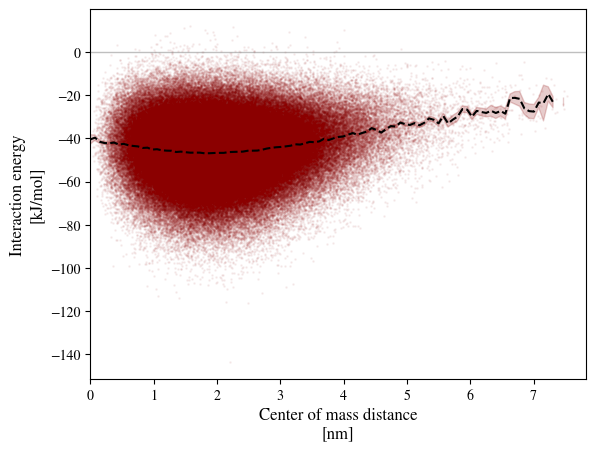

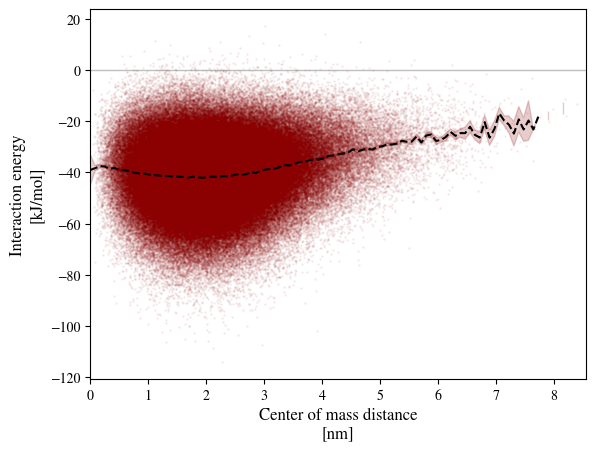

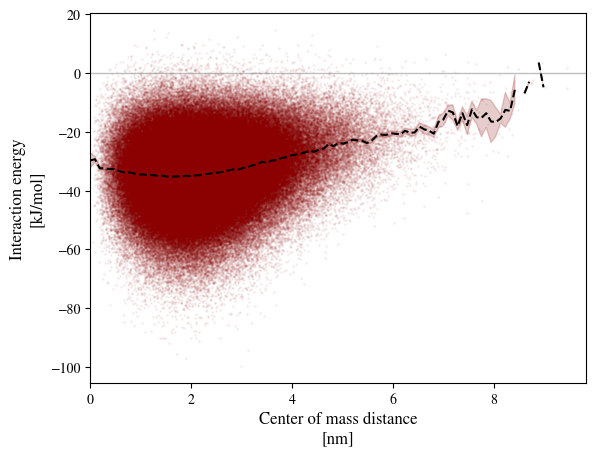

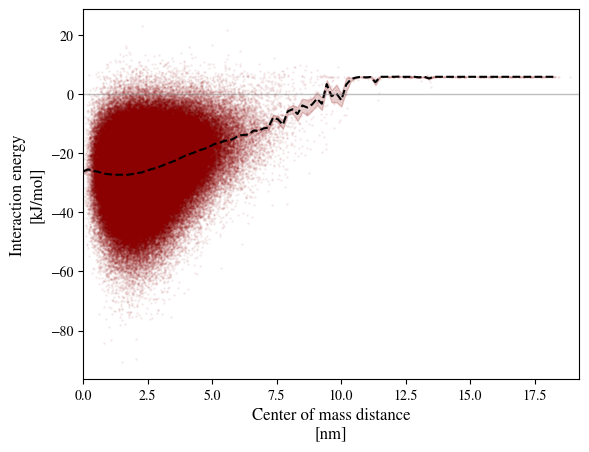

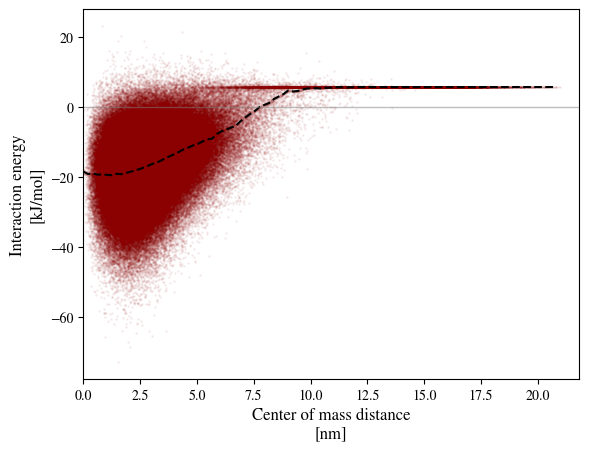

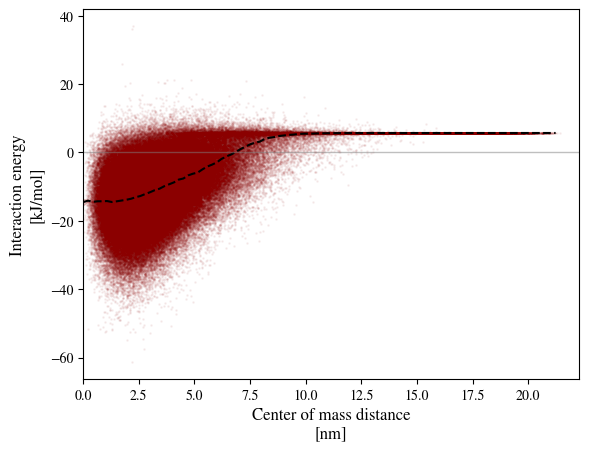

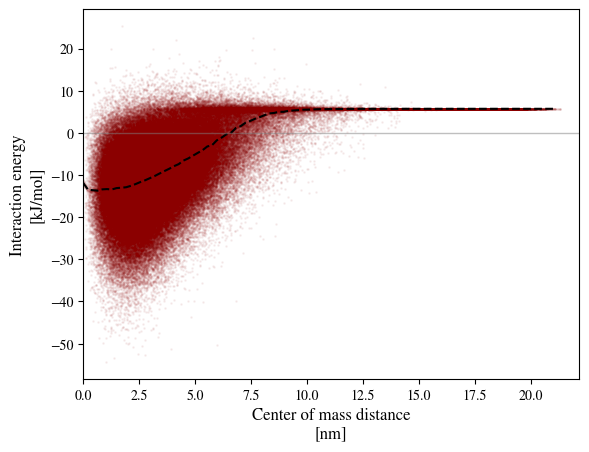

In [3]:
# Calculating Kds and assessing proper sampling
Kds = data.groupby('condition').apply(lambda df: analyse_utils.compute_Kd(df['Total energy [kJ/mol]'], df['Center of mass distance [nm]'], df['T'], 100))
cutoff = 4
Kds = pd.DataFrame({
    "ionic": data.groupby('condition').ionic.max(),
    "Borgia": [2.1e-3, 37e-3, 1, 25, 2.3e2, 1.4e3, 4.0e3],
    "CALVADOS": Kds,
    "sampled": data.groupby('condition').apply(lambda df: any(df['Minimum interresidue distance [nm]'] > cutoff))
})

In [4]:
Kds

,ionic,Borgia,CALVADOS,sampled
condition,,,,
ionic_165,0.165,0.0021,361.200508,False
ionic_180,0.180,0.0370,141.404525,False
ionic_205,0.205,1.0000,4.854595,False
ionic_240,0.240,25.0000,21.073440,True
ionic_290,0.290,230.0000,510.657298,True
ionic_330,0.330,1400.0000,3299.678375,True
ionic_340,0.340,4000.0000,4682.735166,True


In [ ]:
# Determining errors
Borgia_errors = np.array([[1.1e-3, 5e-3, 0.1, 3, 1.5e2, 0.4e3, 1.8e3],
                          [0.8e-3, 5e-3, 0.1, 3, 1.5e2, 0.4e3, 1.8e3]])

# Bootstrapping standard errors
Kd_stderrs = []
for conditions in Kds.index:
    boot_Kds = []
    for i in range(1):
        d = data[data.ionic == 0.240][['Total energy [kJ/mol]', 'Center of mass distance [nm]', 'T']].sample(frac=1, replace=True).to_numpy()
        Kd = analyse_utils.compute_Kd(d[:,0], d[:,1], d[0,2], 100, plot=False)
        boot_Kds.append(Kd)
    Kd_stderr = np.array(boot_Kds).std(ddof=1)
    Kd_stderrs.append(Kd_stderr)
CALVADOS_errors = np.array([Kd_stderrs, Kd_stderrs])

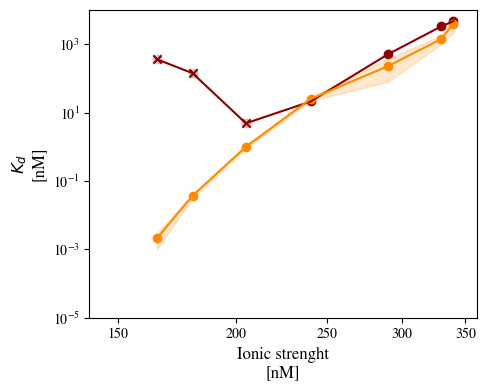

In [11]:
# Plotting results
plt.figure(figsize=(5,4))

plt.xlim(0.140,0.360)
plt.ylim(1e-5, 1e4)
plt.xlabel("Ionic strenght\n[nM]", fontsize=12)
plt.ylabel("$K_d$\n[nM]", fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xticks([0.150, 0.200, 0.250, 0.300, 0.350], [150, 200, 250, 300, 350])

plt.plot(Kds.ionic, Kds.CALVADOS, color='darkred')
plt.scatter(Kds[~Kds.sampled].ionic, Kds[~Kds.sampled].CALVADOS,  marker='x', color='darkred')
plt.scatter(Kds[~Kds.sampled].ionic, Kds[~Kds.sampled].CALVADOS, color='darkred', alpha=0.2)
plt.scatter(Kds[Kds.sampled].ionic, Kds[Kds.sampled].CALVADOS, color='darkred')

plt.scatter(Kds.ionic, Kds.Borgia,color='darkorange')
plt.plot(Kds.ionic, Kds.Borgia, color='darkorange')
plt.fill_between(Kds.ionic, Kds.Borgia-Borgia_errors[0], Kds.Borgia+Borgia_errors[1], color='darkorange', alpha=0.2)


##### Distance cutoffs for $K_d$

/tmp/ipykernel_16818/881686017.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.plot(cutoffs, ((state[:, np.newaxis] > cutoffs).sum(axis=0))/(((state[:, np.newaxis] < cutoffs).sum(axis=0))**2), label='Min. distance')
/tmp/ipykernel_16818/881686017.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(cutoffs, ((state[:, np.newaxis] > cutoffs).sum(axis=0))/(((state[:, np.newaxis] < cutoffs).sum(axis=0))**2), label='Min. distance')
/tmp/ipykernel_16818/881686017.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.plot(cutoffs, ((state[:, np.newaxis] > cutoffs).sum(axis=0))/(((state[:, np.newaxis] < cutoffs).sum(axis=0))**2), label='CoM distance')
/tmp/ipykernel_16818/881686017.py:8: Runtime

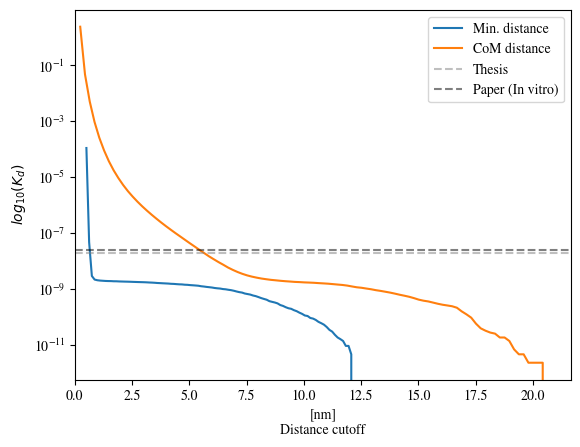

In [47]:
# Binning energy by collective variabl
state = data['Minimum interresidue distance [nm]']
cutoffs = np.linspace(min(state), max(state), 100)
plt.plot(cutoffs, ((state[:, np.newaxis] > cutoffs).sum(axis=0))/(((state[:, np.newaxis] < cutoffs).sum(axis=0))**2), label='Min. distance')

state = data['Center of mass distance [nm]']
cutoffs = np.linspace(min(state), max(state), 100)
plt.plot(cutoffs, ((state[:, np.newaxis] > cutoffs).sum(axis=0))/(((state[:, np.newaxis] < cutoffs).sum(axis=0))**2), label='CoM distance')

plt.xlim(0)
plt.hlines(Kd, *plt.xlim(), linestyles='--', color='grey', alpha=0.5, label='Thesis')
plt.hlines(25e-9, *plt.xlim(), linestyles='--', color='black', alpha=0.5, label='Paper (In vitro)')

plt.yscale('log')
plt.xlabel("[nm]\nDistance cutoff")
plt.ylabel('$log_{10}(K_d)$')
plt.legend()

##### Structural measures

In [10]:
# Loading trajectories
trajs =[]
for condition in Kds.index:
    dir = f"results/two_chain_25nm/{condition}/H1-0_PROTA_WT_25nm"
    traj = md.load_dcd(dir+'/traj.dcd', dir+'/top.pdb')
    trajs.append(traj)
Kds['traj'] = trajs

In [12]:
# Calculating structural measures
Kds['Rg'] = Kds.apply(lambda row: analyse_utils.compute_rg(row.traj).mean(), axis=1)
Kds['Delta'] = Kds.apply(lambda row: analyse_utils.compute_asphericity(row.traj), axis=1)
Kds['S'] = Kds.apply(lambda row: analyse_utils.compute_prolateness(row.traj), axis=1)
Kds['nu'] = Kds.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj), axis=1)

Rg done.
Delta done.
S done.
nu done.


In [13]:
print(Kds['Rg'].to_list())
print(Kds['Delta'].to_list())
print(Kds['S'].to_list())
print(Kds['nu'].to_list())

[3.373787307857228, 3.4242866252736537, 3.517224709620785, 3.657004733585645, 3.9772513357802817, 4.782227808777175, 4.991693880053031]
[0.15472646137638335, 0.15259639249939014, 0.15425561741527435, 0.15484212162126462, 0.19038900389053165, 0.2091769862787268, 0.20693766665840388]
[0.5934278112874142, 0.588544187575298, 0.5854009934262895, 0.6882119120567836, 2.251280766430526, 3.339003832829314, 3.124619533453114]
[(0.4834547256810068, 0.0006464859961725844, 0.518, None), (0.4880257032627575, 0.0006412617619769883, 0.518, None), (0.495800855763527, 0.0006324807432844747, 0.518, None), (0.5100230156411346, 0.0006077172682586728, 0.518, None), (0.5556546951027764, 0.00048003101553983056, 0.518, None), (0.6044765318775934, 0.0003264917541213814, 0.518, None), (0.6108821492780371, 0.0003093969189776105, 0.518, None)]


#### FRET

In [2]:
# Loading trajectory
resultsdir = "results/two_chain_25nm/ionic_165/H1-0_PROTA_WT_25nm/"
traj = md.load_dcd(resultsdir+'traj.dcd', resultsdir+'top.pdb')

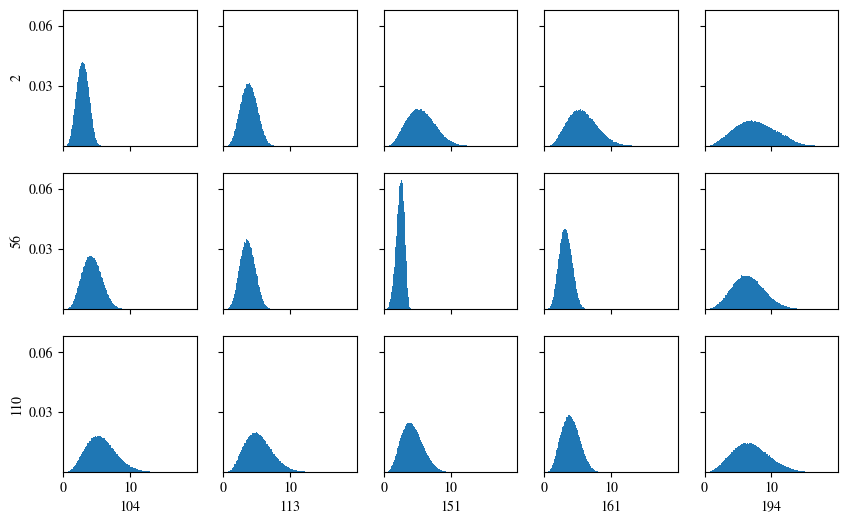

In [67]:
# Assembling FRET label pairs
import itertools
H1_labels = np.array([104, 113, 151, 161, 194]) - 83
P_labels = np.array([2, 56, 110])
pairs = traj.top.select_pairs(P_labels, H1_labels)
distances = md.compute_distances(traj, pairs)

fig, axes = plt.subplots(len(P_labels), len(H1_labels), figsize=(10, 6), sharex=True, sharey=True)
axes = axes.flatten()
for i, pair in enumerate(pairs):
    ax = axes[i]
    if i % 5 == 0:
        ax.set_ylabel(P_labels[i//5])
        ax.set_yticks(np.array([10000,20000]), (np.array([10000,20000])/traj.n_frames).round(2))
    if i > 9:
        ax.set_xlabel(H1_labels[i-10]+83)
    ax.hist(distances[:,i], bins=np.linspace(0,20,200))
plt.xlim(0, 20)
plt.xticks([0,10])
plt.show()

#### Structural changes

In [37]:
# Loading trajectory
ionic = 290
resultsdir = f"results/two_chain_25nm/ionic_{ionic}/H1-0_PROTA_WT_25nm/"
traj_data = data[data.ionic == ionic/1000]
traj = md.load_dcd(resultsdir+'traj.dcd', resultsdir+'top.pdb')[:len(traj_data)]

In [38]:
h10_traj = traj.atom_slice(traj.top.select('chainid 0'))
prota_traj = traj.atom_slice(traj.top.select('chainid 1'))

In [39]:
h10_rg = analyse_utils.compute_rg(h10_traj)
prota_rg = analyse_utils.compute_rg(prota_traj)

h10_com = analyse_utils.compute_com(h10_traj)
prota_com = analyse_utils.compute_com(prota_traj)

bound = traj_data['Minimum interresidue distance [nm]'] < 4

In [ ]:
plt.subplots(212)
plt.hist(prota_rg[bound], weights=np.ones_like(prota_rg[bound]) / len(prota_rg[bound]), bins=100, alpha=0.8, label='Bound', color='darkred')
plt.hist(prota_rg[~bound], weights=np.ones_like(prota_rg[~bound]) / len(prota_rg[~bound]), bins=100, alpha=0.8, label='Unbound', color='grey')
plt.xlabel('$\left\langle R_g \\right\\rangle$')
plt.ylabel('Frequency')
plt.title('ProT$\\textalpha$')

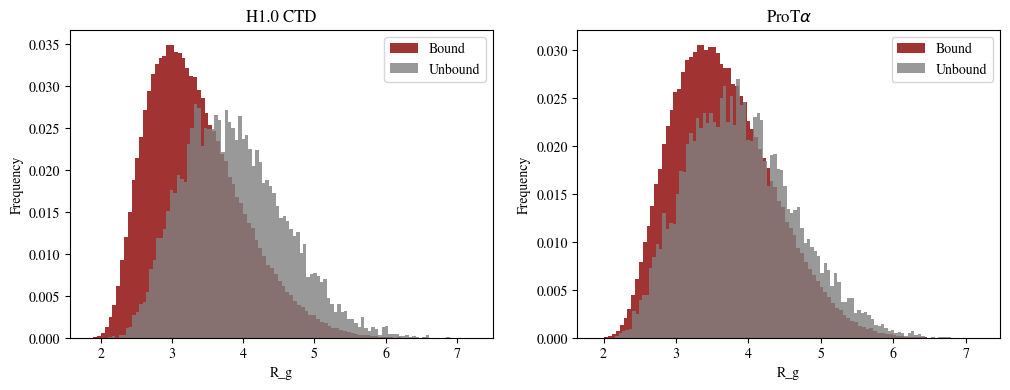

In [73]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(h10_rg[bound], weights=np.ones_like(h10_rg[bound]) / bound.sum(), bins=100, alpha=0.8, label='Bound', color='darkred')
plt.hist(h10_rg[~bound], weights=np.ones_like(h10_rg[~bound]) / (~bound).sum(), bins=100, alpha=0.8, label='Unbound', color='grey')
plt.xlabel('$R_g$')
plt.ylabel('Frequency')
plt.title('H1.0 CTD')
plt.legend(loc='upper right')

plt.subplot(122)
plt.hist(prota_rg[bound], weights=np.ones_like(prota_rg[bound]) / bound.sum(), bins=100, alpha=0.8, label='Bound', color='darkred')
plt.hist(prota_rg[~bound], weights=np.ones_like(prota_rg[~bound]) / (~bound).sum(), bins=100, alpha=0.8, label='Unbound', color='grey')
plt.xlabel('$R_g$')
plt.ylabel('Frequency')
plt.title('ProT'+'$\\alpha$')
plt.legend(loc='upper right')


In [84]:
print("H1.0 bound Rg:", h10_rg[bound].mean())
print("H1.0 unbound Rg:", h10_rg[~bound].mean())

print("ProTa bound Rg:", prota_rg[bound].mean())
print("ProTa unbound Rg:", prota_rg[~bound].mean())

H1.0 bound Rg: 3.329788870827389
H1.0 unbound Rg: 3.870481659897326
ProTa bound Rg: 3.6560044140922145
ProTa unbound Rg: 3.8959904244424206


In [79]:
print("H1.0 bound Delta:", analyse_utils.compute_asphericity(h10_traj[bound[bound].index]))
print("H1.0 unbound Delta:", analyse_utils.compute_asphericity(h10_traj[bound[~bound].index]))

print("ProTa bound Delta:", analyse_utils.compute_asphericity(prota_traj[bound[bound].index]))
print("ProTa unbound Delta:", analyse_utils.compute_asphericity(prota_traj[bound[~bound].index]))

H1.0 bound Delta: 0.24270178076404972
H1.0 unbound Delta: 0.25718041301225497
ProTa bound Delta: 0.2599991378002903
ProTa unbound Delta: 0.27656226991484145


In [80]:
print("H1.0 bound S:", analyse_utils.compute_prolateness(h10_traj[bound[bound].index]))
print("H1.0 unbound S:", analyse_utils.compute_prolateness(h10_traj[bound[~bound].index]))

print("ProTa bound S:", analyse_utils.compute_prolateness(prota_traj[bound[bound].index]))
print("ProTa unbound S:", analyse_utils.compute_prolateness(prota_traj[bound[~bound].index]))

H1.0 bound S: 1.3797958775740033
H1.0 unbound S: 1.4100285565575732
ProTa bound S: 1.4316437591438935
ProTa unbound S: 1.531142736538548


H1.0 bound nu: 0.6153262477537884
H1.0 unbound nu: 0.6468505324097864
ProTa bound nu: 0.6335942604578639
ProTa unbound nu: 0.6479044258504898


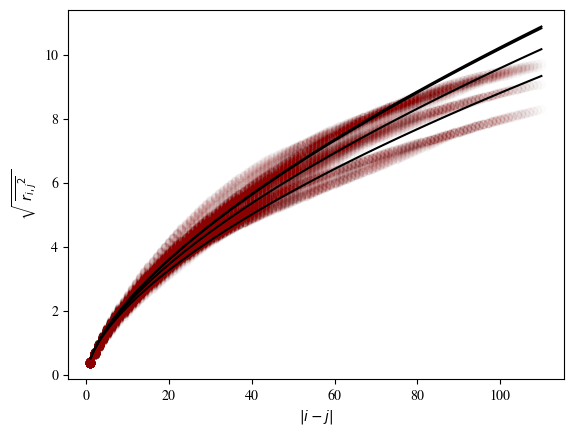

In [83]:
print("H1.0 bound nu:", analyse_utils.compute_scaling_exponent(h10_traj[bound[bound].index], plot=True)[0])
print("H1.0 unbound nu:", analyse_utils.compute_scaling_exponent(h10_traj[bound[~bound].index], plot=True)[0])

print("ProTa bound nu:", analyse_utils.compute_scaling_exponent(prota_traj[bound[bound].index], plot=True)[0])
print("ProTa unbound nu:", analyse_utils.compute_scaling_exponent(prota_traj[bound[~bound].index], plot=True)[0])

#### Contact maps

In [4]:
# Loading trajectory
ionic = 290
resultsdir = f"results/two_chain_25nm/ionic_{ionic}/H1-0_PROTA_WT_25nm/"
traj_data = data[data.ionic == ionic/1000]
traj = md.load_dcd(resultsdir+'traj.dcd', resultsdir+'top.pdb')[:len(traj_data)]
bound = traj_data['Minimum interresidue distance [nm]'] < 4

##### Distance

In [14]:
# Computing distances
pairs = traj.top.select_pairs('chainid 0', 'chainid 1')
distances = md.compute_distances(traj[bound[bound].index], pairs)
distances = distances.reshape((distances.shape[0], 111,111))

Text(0, 0.5, 'H1.0 CTD position')

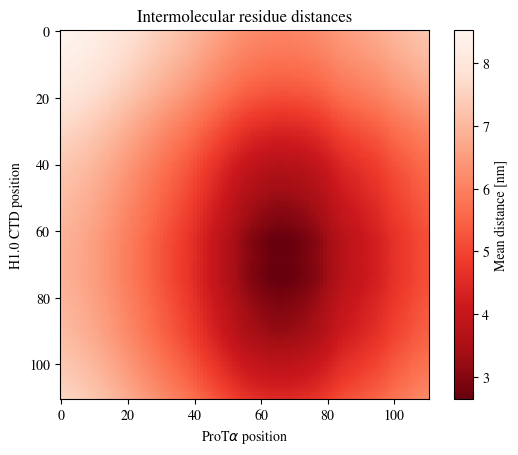

In [15]:
# Contact map
plt.imshow(distances.mean(axis=0), cmap='Reds_r')
plt.title("Intermolecular residue distances")
plt.colorbar(label="Mean distance [nm]")
plt.xlabel('ProT'+'$\\alpha$ position')
plt.ylabel('H1.0 CTD position')

##### Energy

In [16]:
# Computing energy
pairs = traj.top.select_pairs('chainid 0', 'chainid 1')
ah, dh = analyse_utils.compute_energy(traj[bound[bound].index][::10], cond=f'ionic_{ionic}', pairs_ij=pairs)
ah, dh = ah.reshape((dh.shape[0], 111, 111)), dh.reshape((dh.shape[0], 111, 111))

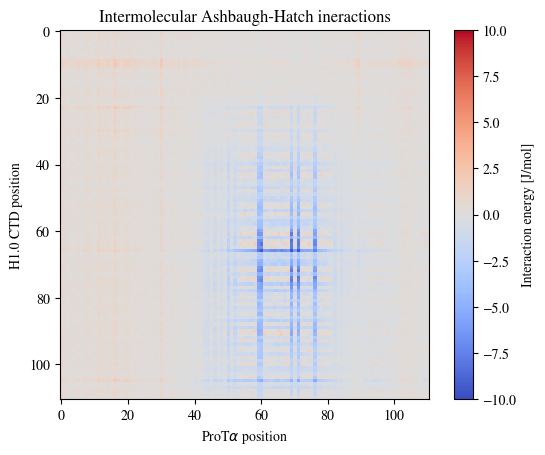

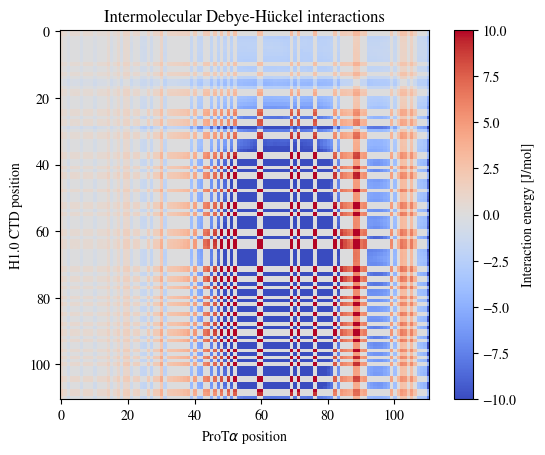

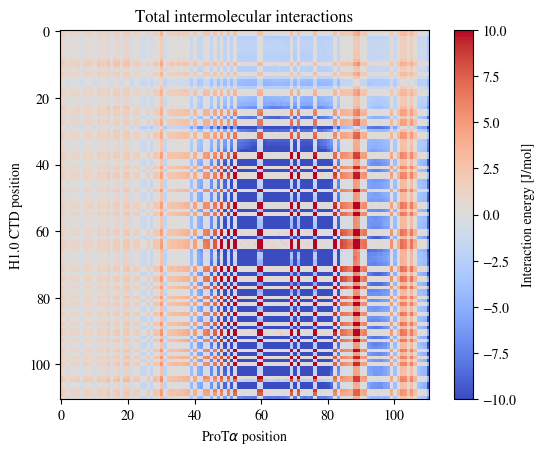

In [18]:
# Plotting energy contact maps
plt.imshow(ah.mean(axis=0)*1000, vmin=-10, vmax=10, cmap='coolwarm')
plt.title("Intermolecular Ashbaugh-Hatch ineractions")
plt.colorbar(label="Interaction energy [J/mol]")
plt.xlabel('ProT'+'$\\alpha$ position')
plt.ylabel('H1.0 CTD position')
plt.show()

plt.imshow(dh.mean(axis=0)*1000, vmin=-10, vmax=10, cmap='coolwarm')
plt.title("Intermolecular Debye-Hückel interactions")
plt.colorbar(label="Interaction energy [J/mol]")
plt.xlabel('ProT'+'$\\alpha$ position')
plt.ylabel('H1.0 CTD position')
plt.show()

plt.imshow((ah+dh).mean(axis=0)*1000, vmin=-10, vmax=10, cmap='coolwarm')
plt.title("Total intermolecular interactions")
plt.colorbar(label="Interaction energy [J/mol]")
plt.xlabel('ProT'+'$\\alpha$ position')
plt.ylabel('H1.0 CTD position')
plt.show()

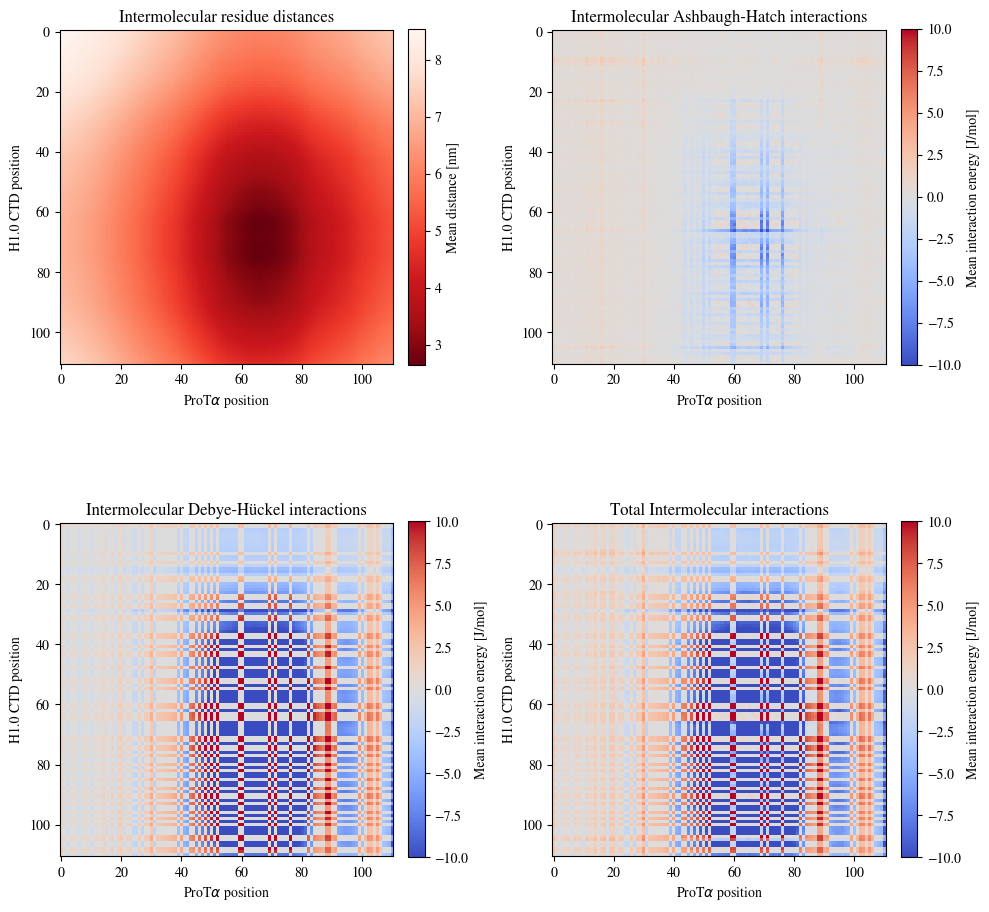

In [20]:
# Combined plot
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(distances.mean(axis=0), cmap='Reds_r')
plt.title("Intermolecular residue distances")
plt.xlabel('ProT'+'$\\alpha$ position')
plt.ylabel('H1.0 CTD position')
plt.colorbar(label="Mean distance [nm]", fraction=0.046, pad=0.04)

plt.subplot(222)
plt.imshow(ah.mean(axis=0)*1000, vmin=-10, vmax=10, cmap='coolwarm')
plt.title("Intermolecular Ashbaugh-Hatch interactions")
plt.xlabel('ProT'+'$\\alpha$ position')
plt.ylabel('H1.0 CTD position')
plt.colorbar(label="Mean interaction energy [J/mol]", fraction=0.046, pad=0.04)

plt.subplot(223)
plt.imshow(dh.mean(axis=0)*1000, vmin=-10, vmax=10, cmap='coolwarm')
plt.title("Intermolecular Debye-Hückel interactions")
plt.xlabel('ProT'+'$\\alpha$ position')
plt.ylabel('H1.0 CTD position')
plt.colorbar(label="Mean interaction energy [J/mol]", fraction=0.046, pad=0.04)

plt.subplot(224)
plt.imshow((ah+dh).mean(axis=0)*1000, vmin=-10, vmax=10, cmap='coolwarm')
plt.title("Total Intermolecular interactions")
plt.xlabel('ProT'+'$\\alpha$ position')
plt.ylabel('H1.0 CTD position')
plt.colorbar(label="Mean interaction energy [J/mol]", fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Three chain wild type ProTa - H1.0[CTD]

In [28]:
# Loading trajectories
top = "H1-0_2xPROTA_WT"
conds = ["default", "Borgia_in_silico", "ionic_165", "ionic_180", "ionic_205", "ionic_240", "ionic_290", "ionic_330", "ionic_340"]
charge_map = {
    42: 'H1-0 CTD',
    -44: 'ProTa'
}

# Loading trajectories and gathering sequence data
traj = {}
residues = {}
for cond in conds:
    dir = f"results/three_chain/{cond}/{top}"
    traj[cond] = md.load_dcd(f"{dir}/pretraj.dcd", f"{dir}/top.pdb")[1000:]
    residues[cond] = simulate_utils.extract_sequences(f"{dir}/top.pdb")
    

# Mapping chains by charge
chain_map = {}
for i, q in residues[conds[0]].groupby('chain').q.sum().items():
    chain_map[i] = charge_map[q]
for cond in conds:
    residues[cond]['chain_id'] = residues[cond]['chain'].map(chain_map)

dcdplugin) Warning: DCD header claims 14756 frames, file size indicates there are actually 14757 frames


In [30]:
# Centering trajectories around middle protein
for cond in conds:
    center_chain = 1
    chains = traj[cond].topology.find_molecules()
    assert len(chains) == 3, f"Topology for '{cond}' has wrong CONECT lines!"
    anchor_chain = [traj[cond].topology.find_molecules()[center_chain]]
    traj[cond].image_molecules(inplace=True, anchor_molecules=anchor_chain)

In [19]:
# Saving recentered trajs
for cond in conds:
    dir = f"results/three_chain/{cond}/{top}"
    traj[cond].save_dcd(f"{dir}/traj.dcd")

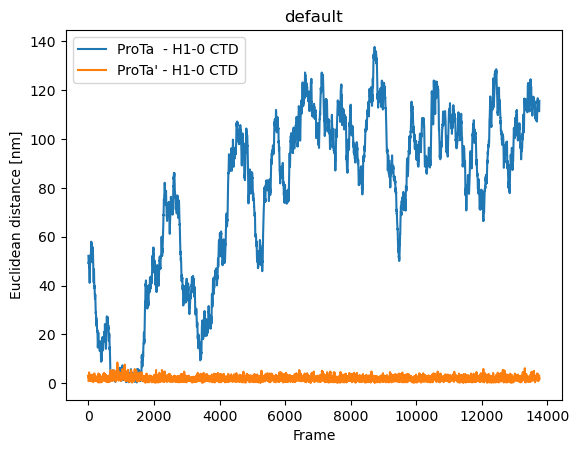

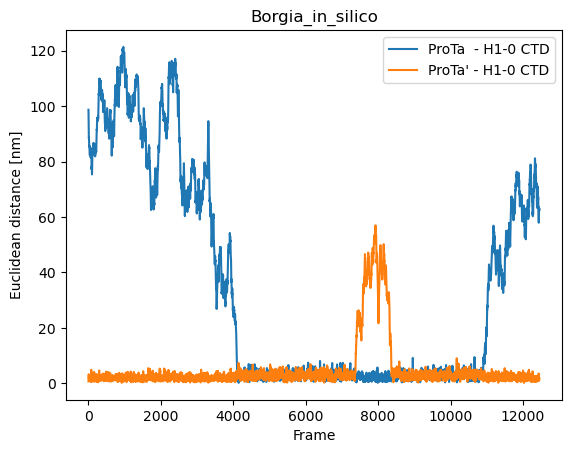

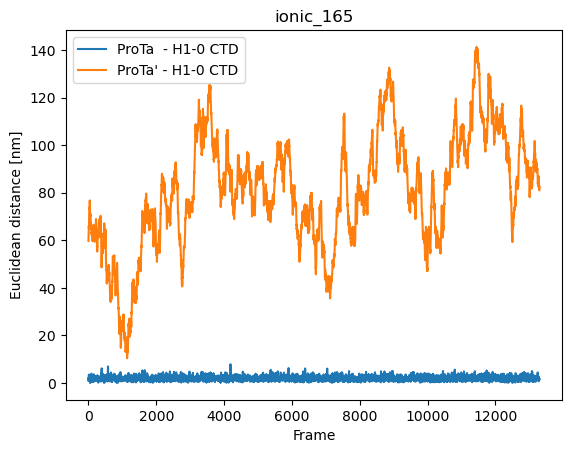

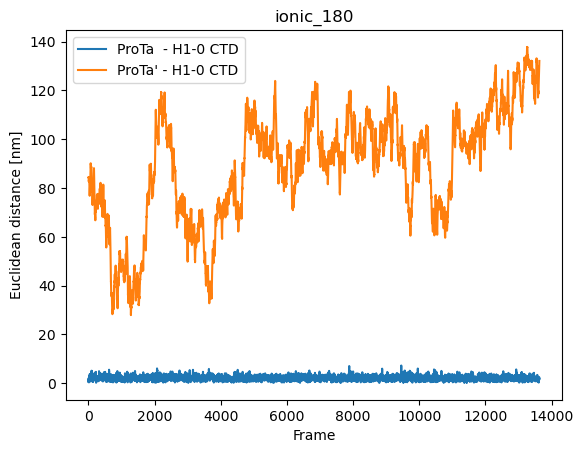

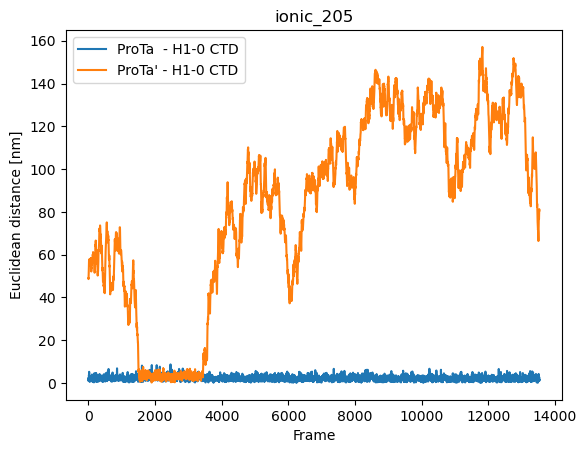

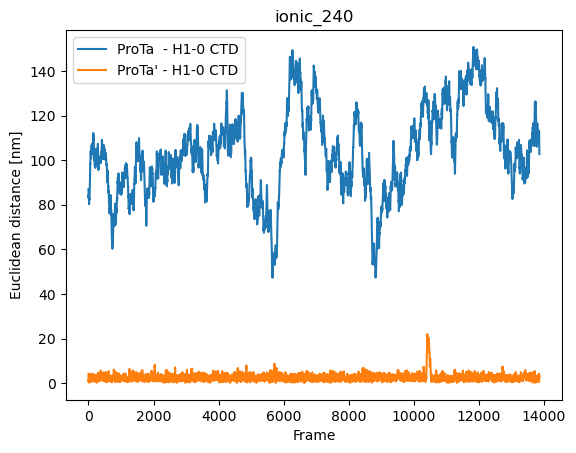

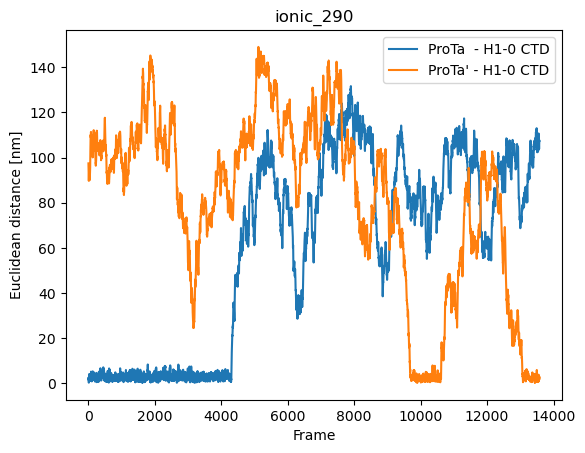

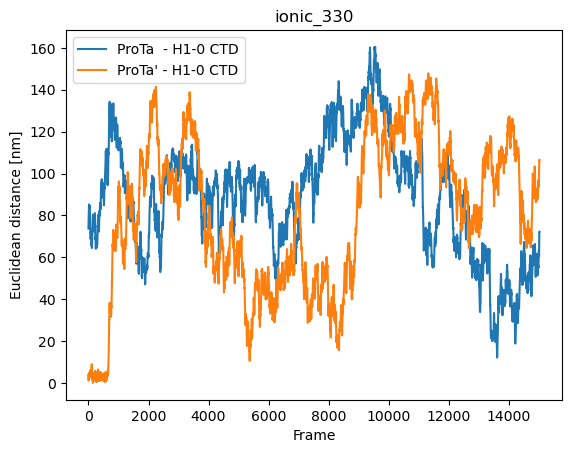

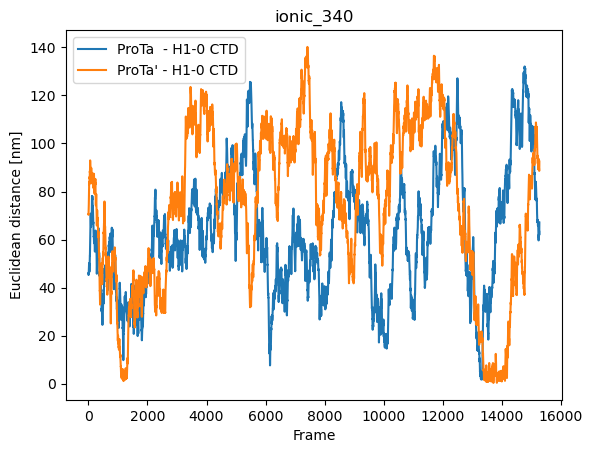

In [31]:
# Computing center of mass c
for cond in conds:
    c1 = analyse_utils.compute_com(''.join(residues[cond].aa[residues[cond].chain == 0]), traj[cond].atom_slice(residues[cond].res[residues[cond].chain == 0]))
    c2 = analyse_utils.compute_com(''.join(residues[cond].aa[residues[cond].chain == 1]), traj[cond].atom_slice(residues[cond].res[residues[cond].chain == 1]))
    c3 = analyse_utils.compute_com(''.join(residues[cond].aa[residues[cond].chain == 2]), traj[cond].atom_slice(residues[cond].res[residues[cond].chain == 2]))
    com_diff_1 = (((c1-c2)**2).sum(axis=1))**0.5
    com_diff_2 = (((c3-c2)**2).sum(axis=1))**0.5
    plt.plot(com_diff_1, label=f"{chain_map[0]}  - {chain_map[1]}")
    plt.plot(com_diff_2, label=f"{chain_map[2]}' - {chain_map[1]}")
    plt.legend()
    plt.title(cond)
    plt.xlabel("Frame")
    plt.ylabel("Euclidean distance [nm]")
    plt.show()